--OVERVIEW--

This notebook serves to explain and demonstrate a game, and the AI designed by this team to play it out. The game, called Hogwarts Hobos, is a survival game similar to the classic arcade game Frogger with one key difference. Instead of trying to make it across some series of obstacles, you are trying to stay alive as long as possible while remaining in the path of danger.

The game is as follows. The user controls a Hobo who currently finds himself on the tracks of a subway tunnel. There are N number of tracks in the tunnel, there is on average L0 seconds between trains on each track, and each train is on the track for on average L1 seconds. See accompanied picture "hoboOnTracks.png" for a representation of the game. The hobo begins the game with 20 health points (hp), each time a train strikes the hobo he loses 1hp. The goal is to jump back and forth on the tracks to avoid trains and live as long as possible.

--MISSION--
We decided that instead of actually creating a game that a user could play, we wanted to figure out what would be the best way to play this game. So we set about creating a program that would model the behaviour of trains on tracks, and create a variety of "player profiles" that would act in different ways and measure their sucess under different conditions.

In [1]:
#--TrainTrack Class-- this object is used to model the behaviour of a train track for a given duration
import poisson
import random
class TrainTrack:
    def __init__(self,L0,L1):
        self.L0=poisson.poissonValues(L0)
        self.L1=poisson.poissonValues(L1)
        self.hasTrain=False
        self.isWaiting=False
        self.trackOccupancy=[0]

    def getTimeBetweenTrains(self):
        r=random.randint(0,100)
        for key, val in self.L0.items():
            if r<= val:
                return key
        return list(self.L0.keys())[len(self.L0.keys())-1]

    def getHowLong(self):
        r=random.randint(0,100)
        for key, val in self.L1.items():
            if r<= val:
                return key
        return list(self.L1.keys())[len(self.L1.keys())-1]

    def simulate(self,duration):
        waitFor=0
        thisTrain=0
        if(random.randint(1,100)>50):
            self.isWaiting=True
            waitFor=self.getTimeBetweenTrains()
        for i in range (1,duration):

            if self.isWaiting==True and i >= waitFor:
                self.isWaiting=False
            if self.hasTrain and i >=thisTrain:
                self.hasTrain = False
            if self.hasTrain == False and self.isWaiting==False:
                self.hasTrain=True
                self.isWaiting=True
                thisTrain = i + self.getHowLong()
                waitFor = thisTrain + self.getTimeBetweenTrains()
            if self.hasTrain == True:
                self.trackOccupancy.append(1)
            else:
                self.trackOccupancy.append(0)
        return self.trackOccupancy


Initializing a Train Track requires inputting L0 and L1 values. These are,respectively, the average time between trains, and the average duration of a train. Running the simulate() function will generate a 1-dimensional list of 1's and 0's that represent whether or not a train is on the track at that given moment. Each index in the list corresponds to a given time frame, in our case we use each index to correspond to a "game second"

In [2]:
train = TrainTrack(5,3) #This train track will have on average 5 seconds between trains, and each train will on average be 3 seconds long.
print(train.simulate(60))


[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


As you can see, in 60 seconds we have 6 trains and 7 gaps, all of varying lengths. This is achieved using Poisson distribution, called via poisson.py

In [3]:
import math
from decimal import Decimal
e=math.e
import random

class my_dictionary(dict): 
  
    def __init__(self): 
        self = dict() 
          
    def add(self, key, value): 
        self[key] = value 


def poisson(k, l):
    exp = math.pow(e,-l)
    lambdaPower = l**k
    num = Decimal(exp*lambdaPower)
    denom = Decimal(math.factorial(k))
    return num/denom

def poissonValues(mean):
    
    trainChance=my_dictionary()
    for i in range(100):
        if poisson(i,mean)*100 >=.5:
            trainChance.add(i,round(poisson(i,mean)*100))
    keys=[x for x in trainChance.keys()]
    for i in range(1,len(trainChance.keys())):
        trainChance[keys[i]]=trainChance[keys[i]]+trainChance[keys[i]-1]
    return trainChance

The poisson(k,l) function is used to calculate the percentage chance that a given event will occur k times in a time period when the average is l. For example, if you are at the 3-point line on a basketball court and you average 6 baskets in 60 seconds, poisson(7,6)*100 will tell you your chance to hit 7 baskets in 60 seconds.

In [5]:
print(poisson(7,6)*100)

13.76769780411257847339988479


The poissonValues(mean) function, returns a dictionary where the keys represent real world possibilities for the given mean (those possibilities that have >.5%). The values represent the percent chance associated with that key.

In [7]:
print(poissonValues(6))

{1: 1, 2: 5, 3: 14, 4: 27, 5: 43, 6: 59, 7: 73, 8: 83, 9: 90, 10: 94, 11: 96, 12: 97, 13: 98}


Continuing our 3-pointer example. You have a 1% chance of hitting 1 basket in 60 seconds, a 4% chance of hitting 2 baskets, a 9% chance of hitting 3 baskets, and so on. It should be noted here that the percent chance for a given key "N" can be calculated as follows:

P(N)= (Value of N) - (Value of (N-1))

This dictionary is what is used to pseudo randomly generate our train track profiles. This is akin to using a "weighted random number."


We can put all this together and graphically represent a simulation of train behaviour given user inputs of: avgTimeBetweenTrains, avgTrainDuration, numTrains, duration.

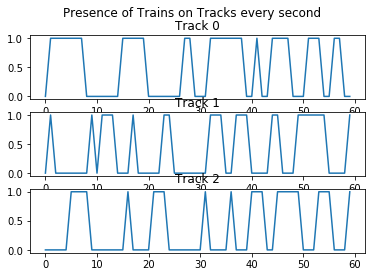

In [10]:
import poisson
import matplotlib.pyplot as plt
from traintrack import TrainTrack

def simulateTrains(L0,L1,numTrains,duration):
    tracks = [TrainTrack(L0,L1) for x in range(numTrains)]
    results=[x.simulate(duration) for x in tracks]
    # print(results)
    fig,ax = plt.subplots(numTrains)
    fig.suptitle("Presence of Trains on Tracks every second")
    for i in range(len(results)):
        
        ax[i].plot([x for x in range (duration)],results[i])
        ax[i].set_title("Track "+str(i))
        
    plt.show()

simulateTrains(5,3,3,60)


To reiterate, "1" represents the presence of a train on that track and "0" the absence of a train.

Now that we have successfully modeled the train track behaviour let us move on to the Hobo!

In [ ]:
#--Hobo Class-- This object represents the "player" he comes keeps track of his life total, his position history, and information about the tracks around him. The act(smartness) function changes his position based on the conditions around him, there are 5 different ways to make decisions. These were numbered in terms of simplicity.
import poisson
import random
class Hobo:
    
    def __init__(self):
        self.hp=20
        self.position=0
        self.info=[[],[]] #List of lists, first represents the trainState of tracks this second, second list for next second
        self.runningResults=[[]] #memory of tracks that havent changed yet
        self.runningL0=[] #time between trains
        self.runningL1=[] #time of train on track
        self.positionHistory=[0]

    
    def getSuggestion(self,listOfTrackVals):
        self.info[1]=listOfTrackVals

    def act(self,smartness):

        if smartness == 0:
            self.position = random.randint(0,len(self.info[0])-1)
            self.positionHistory.append(self.position)

        elif smartness == 1:

            for i in range(len(self.info[0])):
                if self.info[0][i]==0:
                    self.position = i

                    self.positionHistory.append(self.position)
                    return

            self.positionHistory.append(self.position)
        
        elif smartness == 2:
           
                for i in range(len(self.info[1])):
                    if self.info[1][i]==0:
                        self.position = i

                        self.positionHistory.append(self.position)
                        return
                self.positionHistory.append(self.position)
            else:
                for i in range(len(self.info[0])):
                    if self.info[0][i]==0:
                        self.position = i
                       
                        self.positionHistory.append(self.position)
                        return
                
                self.positionHistory.append(self.position)
        elif smartness ==3:
            
            if self.runningL0 and self.runningL1  and (0 not in self.info[0]):
                trackSafeness = self.doMaths()

                self.position = trackSafeness.index(max(trackSafeness))
                self.positionHistory.append(self.position)

            else:

                for i in range(len(self.info[0])):
                    if self.info[0][i]==0:
                        self.position = i

                        self.positionHistory.append(self.position)
                        return
                self.positionHistory.append(self.position)
        else:
            if self.runningL0 and self.runningL1:
                trackSafeness = self.doMaths()

                while self.info[0][trackSafeness.index(max(trackSafeness))] != 0 and len(trackSafeness)>1:
                    trackSafeness.pop(trackSafeness.index(max(trackSafeness)))
                    
                self.position = trackSafeness.index(max(trackSafeness))
                self.positionHistory.append(self.position)

            else:

                for i in range(len(self.info[0])):
                    if self.info[0][i]==0:
                        self.position = i

                        self.positionHistory.append(self.position)
                        return
                self.positionHistory.append(self.position)

    def updateResults(self):

        for i in range(len(self.info[0])):
            if self.runningResults[i][0]==self.info[0][i]:
                self.runningResults[i].append(self.info[0][i])
            else:
                if self.info[0][i]==1:
                    self.runningL0.append(len(self.runningResults[i]))
                    self.runningResults[i]=[]
                    self.runningResults[i].append(self.info[0][i])

                if self.info[0][i]==0:
                    self.runningL1.append(len(self.runningResults[i]))
                    self.runningResults[i]=[]
                    self.runningResults[i].append(self.info[0][i])

    def doMaths(self):
        
        try: 
            if self.runningL0 and self.runningL1:
                trackSafeness=[]
                runningMeanL0=sum(self.runningL0)/(len(self.runningL0))
                runningMeanL1=sum(self.runningL1)/(len(self.runningL1))

                for x in self.runningResults:
                    if x[0]== 0: #track is empty
                        getValues = poisson.poissonValues(runningMeanL0)
                        key=len(x)+1
                        if key in getValues.keys():
                            trackSafeness.append(100-getValues[key])
                        else:
                            trackSafeness.append(100)

                    if x[0]==1: #track has train
                        
                        getValues = poisson.poissonValues(runningMeanL1)
                        key=len(x)+1
                        if key in getValues.keys():
                            trackSafeness.append(100-getValues[key])
                        else:
                            trackSafeness.append(100)

                return (trackSafeness)
        except(OverflowError):
            print("OVERFLOW ERROR: L0 = "+str(runningMeanL0)+" L1 = "+str(runningMeanL1)+" ")

    def lookAtTracks(self,num,listOfTrackResults):
        self.info[0]= [x[num] for x in listOfTrackResults]

You can find more detailed information about specific functions in the HOBO.md file

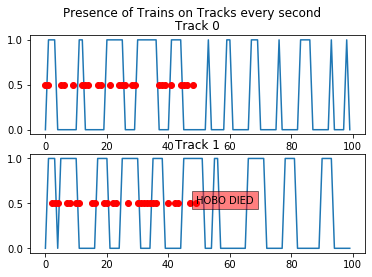

49


In [2]:
import math as math
import matplotlib.pyplot as plt
import pandas as pd
import csv
from matplotlib import cm
import poisson
from statistics import mean
import random
from hobo import Hobo
from traintrack  import TrainTrack
import numpy as np
from mpl_toolkits import mplot3d

def simulateGame(L0,L1,numTrains,lengthOfGame,hoboSmartness):

    def showGraphs():
        fig,ax = plt.subplots(numTrains)
        fig.suptitle("Presence of Trains on Tracks every second")
        deathTrack=0
        for i in range(len(trackResults)):
            hoboHistoryOnThisTrack=[]
            for j in range(len (dumbledore.positionHistory)):
                if dumbledore.positionHistory[j]==i:
                    hoboHistoryOnThisTrack.append(.5)
                    if j==score:
                        deathTrack = i
                else:
                    hoboHistoryOnThisTrack.append(None)
            ax[i].plot([x for x in range (lengthOfGame)],trackResults[i],hoboHistoryOnThisTrack,'ro')
            ax[i].set_title("Track "+str(i))
        ax[deathTrack].text(score,.5, "HOBO DIED",bbox=dict(facecolor='red', alpha=0.5))
        plt.show()


    #for each time period generate a trainTrack simulation
    tracks = [TrainTrack(L0,L1) for x in range(numTrains)]
    trackResults = [x.simulate(lengthOfGame) for x in tracks]

    #initialize our hobo object
    dumbledore= Hobo()
    dumbledore.runningResults=[[0]for x in range(numTrains)]
    score=lengthOfGame

    #MAIN GAME LOOP, each i represents a game slice or a second of the whole window
    for i in range(lengthOfGame):
        #DID HE GET HIT? Does the track he is on have a 1 at the given index? If so, decrement HP
        if trackResults[dumbledore.position][i]==1:
            dumbledore.hp-=1
            #O SHIT, HE DIED END THE GAME
            if dumbledore.hp==0:
                score=i
                showGraphs()
                return score

        #GET PAPER PLANE
        paperPlane=[]
        if (random.randint(1,100)<=99) and i<lengthOfGame-1:
            
            for y in range(numTrains):
                paperPlane.append(trackResults[y][i+1])

        else:
            for y in range(numTrains):
                paperPlane.append(random.randint(0,1))
            dumbledore.getSuggestion(paperPlane)

        #LOOKS AROUND AT TRAINS

        dumbledore.lookAtTracks(i,trackResults)


        #STORES WHAT HE SEES
        dumbledore.updateResults()


        #JUMP
        dumbledore.act(hoboSmartness)

    
    showGraphs()

    return "GAME OVER! SCORE: " +str(score)

print(simulateGame(5,3,2,100,0)) 

This graph shows train and hobo activity across both tracks. The red dots indicate the presence of the hobo. It should be noted that the hobo's jump or movement is reconciled last in the game loop. Therefore if he had been struck by a train, but later moved to a safe track it may seem as though he was always safe.

Let us compare the activity of hobos of differing "intelligence" levels:

HOBO LEVEL 0


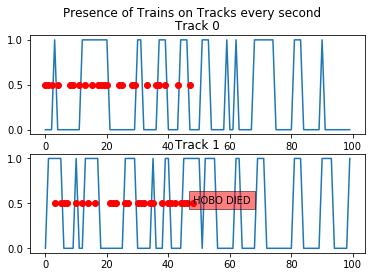

HOBO LEVEL 1


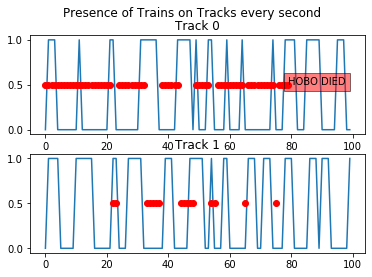

HOBO LEVEL 2


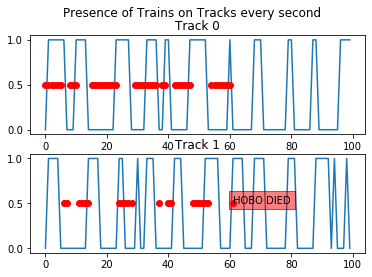

HOBO LEVEL 3


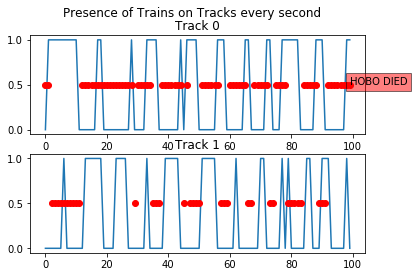

HOBO LEVEL 4


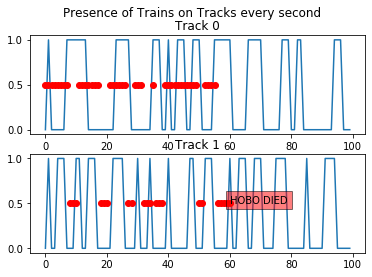

60

In [4]:
print("HOBO LEVEL 0")
simulateGame(5,3,2,100,0)
print("HOBO LEVEL 1")
simulateGame(5,3,2,100,1)
print("HOBO LEVEL 2")
simulateGame(5,3,2,100,2)
print("HOBO LEVEL 3")
simulateGame(5,3,2,100,3)
print("HOBO LEVEL 4")
simulateGame(5,3,2,100,4)

As you can see here it seems that level 1 and 3 performed the best. You may be asking yourself here, what exactly are the differences in these "intelligence" levels. It has to do with the way in which the hobo decides to move to another track. A brief description goes as follows:

LEVEL - 0 : The hobo randomly chooses a track to jump to regardless of where he currently is or what the state of the proposed track is.

LEVEL - 1 : The hobo jumps to the first empty track, if there are no empty tracks he stays in place.

LEVEL - 2 : The hobo jumps to the first empty track, if there are no empty tracks then he relies on the paper plane that was thrown to him (only accurate 60% of the time).

LEVEL - 3 : The hobo jumps to the first empty track, if there are no empty tracks then he uses his memory to calculate the percent chance that a track will be "safe" next second.

LEVEL - 4 : If possible the hobo judges the safeness of each track and jumps to the safest, if there is insufficient data to make a calculation he jumps to the first empty track.

Those previous graphs are representations of performance, but only for a single instance of set parameters. What is the best way to judge the average performance of each hobo across a range of parameter values?

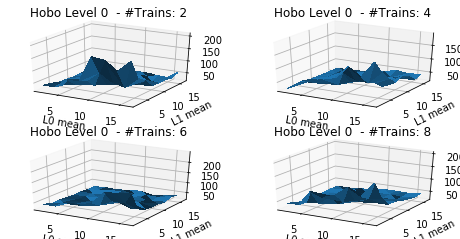

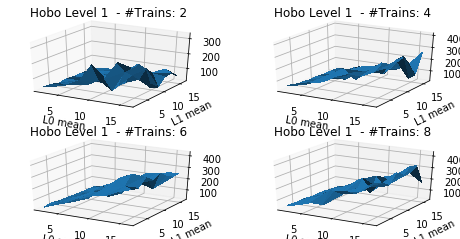

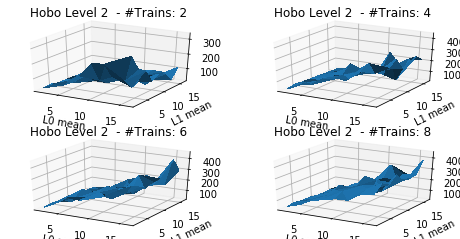

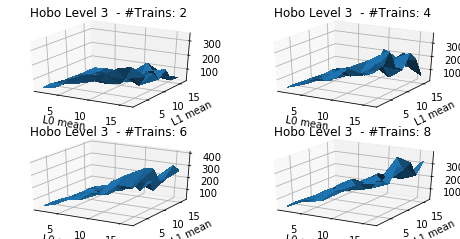

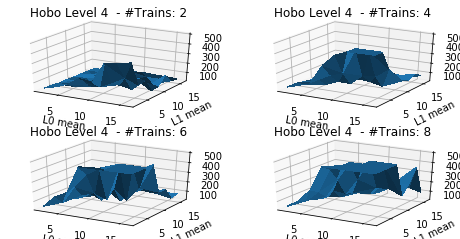

In [11]:
import math as math
import matplotlib.pyplot as plt
import pandas as pd
import csv
from matplotlib import cm
import poisson
from statistics import mean
import random
from hobo import Hobo
from traintrack  import TrainTrack
import numpy as np
from mpl_toolkits import mplot3d

def simulateGame(L0,L1,numTrains,lengthOfGame,hoboSmartness):

    def showGraphs():
        fig,ax = plt.subplots(numTrains)
        fig.suptitle("Presence of Trains on Tracks every second")
        deathTrack=0
        for i in range(len(trackResults)):
            hoboHistoryOnThisTrack=[]
            for j in range(len (dumbledore.positionHistory)):
                if dumbledore.positionHistory[j]==i:
                    hoboHistoryOnThisTrack.append(.5)
                    if j==score:
                        deathTrack = i
                else:
                    hoboHistoryOnThisTrack.append(None)
            ax[i].plot([x for x in range (lengthOfGame)],trackResults[i],hoboHistoryOnThisTrack,'ro')
            ax[i].set_title("Track "+str(i))
        ax[deathTrack].text(score,.5, "HOBO DIED",bbox=dict(facecolor='red', alpha=0.5))
        plt.show()


    #for each time period generate a trainTrack simulation
    tracks = [TrainTrack(L0,L1) for x in range(numTrains)]
    trackResults = [x.simulate(lengthOfGame) for x in tracks]

    #initialize our hobo object
    dumbledore= Hobo()
    dumbledore.runningResults=[[0]for x in range(numTrains)]
    score=lengthOfGame

    #MAIN GAME LOOP, each i represents a game slice or a second of the whole window
    for i in range(lengthOfGame):
        #DID HE GET HIT? Does the track he is on have a 1 at the given index? If so, decrement HP
        if trackResults[dumbledore.position][i]==1:
            dumbledore.hp-=1
            #O SHIT, HE DIED END THE GAME
            if dumbledore.hp==0:
                score=i
                return score

        #GET PAPER PLANE
        paperPlane=[]
        if (random.randint(1,100)<=99) and i<lengthOfGame-1:
            
            for y in range(numTrains):
                paperPlane.append(trackResults[y][i+1])

        else:
            for y in range(numTrains):
                paperPlane.append(random.randint(0,1))
            dumbledore.getSuggestion(paperPlane)

        #LOOKS AROUND AT TRAINS

        dumbledore.lookAtTracks(i,trackResults)


        #STORES WHAT HE SEES
        dumbledore.updateResults()


        #JUMP
        dumbledore.act(hoboSmartness)


    return score
for hoboLevel in range(5):
    fig = plt.figure(figsize = plt.figaspect(0.5))
    for numTrains in range(2,10,2):

        results=[]
        L0axis=[]
        L1axis=[]
        for L0 in range(2,17,2):
            for L1 in range(2,17,2):
                #print("CALCULATING AVERAGE OF SMARTNESS : "+str(i+1))
                for j in range(10):

                    if results!= None:
                        results.append(simulateGame(L0,L1,numTrains,500,hoboLevel))
                    else:
                        results=[simulateGame(L0,L1,numTrains,500,hoboLevel)]
                    L0axis.append(L0)
                    L1axis.append(L1)

        
        ax = fig.add_subplot(2,2,numTrains/2, projection = '3d')
        L0axis=np.array(L0axis)
        L1axis=np.array(L1axis)

        results=np.array(results)

        ax.plot_trisurf(L0axis,L1axis,results,linewidth=0, antialiased=False)

        plt.title("Hobo Level "+str(hoboLevel)+"  - #Trains: "+str(numTrains))
        plt.xlabel("L0 mean")
        plt.ylabel("L1 mean")

    plt.show()

You can see here that there is a proportional relationship between the number of trains and survivability for all hobo levels. Also increases in L0 result in gains of survivability across the board. This makes sense with out intuitive understanding of the game. We can understand L0 as the time between trains, but also as the average "safe period" duration, as this increases it stands to reason that the player would be safer for longer thereby resulting in increased survivability.

These graphs get more interesting when we begin to compare the hobo levels against each other. Profiles 1,2, and 3, are all very similar and this too makes sense because the only variability in these profiles is how they decide to act under a very particular condition. These profiles vary in deciding what to do when there are no empty tracks. #1 stays put, #2 uses the paper plane, and #3 uses math. The conditions that would precipitate variance of this kind are exponentially less likely as the number of trains increases and L0 increases, but also as L1 decreases.

Lastly, let us look at the graphs for level 4. These graphs are most notable for their plateau like structure. There are like areas of these graphs that have very high score. Significantly higher than any other profile. The fact that these are plateaus and not just peaks signifies that the performance gains of this profile are not just unique to a particular set of parameters, but can be considered the overall "winner." The one mitigating factor of hobo level 4's performance is duration. The "learning" portion of this profile requires time in order to refine its understanding of the game conditions. Therefore, this performance increase would be muted if the duration of the game was lower. We can demonstrate the learning portion of this profile by examining the hobo's hit rate over time. If the hobo is truly learning, his hit rate should decrease over time, and then reach a floor.

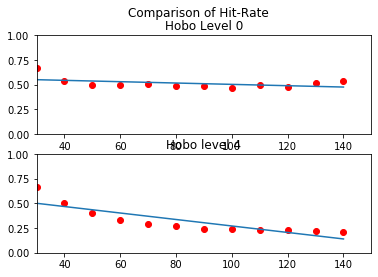

In [15]:
from numpy.polynomial.polynomial import polyfit
results0=[]
results4=[]
x=[]
for i in range (30,150,10):
    x.append(i)
    meanResult0=[]
    meanResult4=[]
    for j in range(25):
        meanResult0.append(simulateGame(7,7,5,i,0))
        meanResult4.append(simulateGame(7,7,5,i,4))
    results0.append(20/mean(meanResult0))
    results4.append(20/mean(meanResult4))
fig,ax = plt.subplots(2)
fig.suptitle("Comparison of Hit-Rate")
custom_ylim=(0,1)
custom_xlim=(30,150)

x=np.array(x)
ax[0].plot(x,results0,'ro')

ax[0].set_title("Hobo Level 0")
b,m = polyfit(x,results0,1)
ax[0].plot(x,b+m*x,'-')
ax[1].plot(x,results4,'ro')
b,m = polyfit(x,results4,1)
ax[1].set_title("Hobo level 4")
ax[1].plot(x,b+m*x,'-')

plt.setp(ax, ylim=custom_ylim,xlim=custom_xlim)
plt.show()

This graph proves our intuition correct, and demonstrates the "learning" capability of our smartest hobo.

--CONCLUSION--

Given our game conditions and the 5 different "Player Profiles" we can say that: 


In [17]:
def displayOverallAverages():
    for hoboLevel in range(5):
        avgScore=[]
        for numTrains in range(2,10,2):

            results=[]
            for L0 in range(1,15,2):
                for L1 in range(1,15,2):
                    #print("CALCULATING AVERAGE OF SMARTNESS : "+str(i+1))
                    for j in range(10):

                        if results!= None:
                            results.append(simulateGame(L0,L1,numTrains,500,hoboLevel))
                        else:
                            results=[simulateGame(L0,L1,numTrains,500,hoboLevel)]
            avgScore.append(mean(results))
        print("Hobo Level: "+str(hoboLevel)+" Overall Average Score: "+str(mean(avgScore)))

displayOverallAverages()

Hobo Level: 0 Overall Average Score: 52.10765306122449
Hobo Level: 1 Overall Average Score: 109.38826530612245
Hobo Level: 2 Overall Average Score: 110.73163265306123
Hobo Level: 3 Overall Average Score: 110.56530612244897
Hobo Level: 4 Overall Average Score: 151.0969387755102


Clearly the best way to play the game is to use the power of MATHEMATICS!!!